In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from joblib import Memory
from shutil import rmtree

from sklearn.metrics import get_scorer
from datetime import datetime

from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = compute_features(df.drop('mortality',axis=1)) #df.drop('mortality',axis=1)
y = df.mortality.values


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

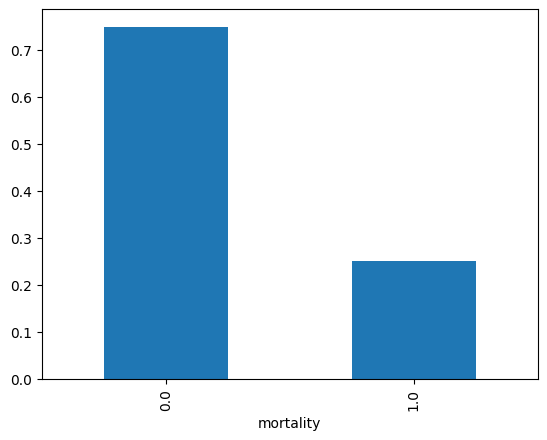

In [4]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [5]:
base_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
]


# GridSearchCV for weight of weighted loss

### Probit

In [6]:
probit_pipeline = base_pipeline + [
    ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=10)),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
    ('model',probitModel()),
]

In [7]:
pipe = Pipeline(probit_pipeline)
param_grid = {
    'model__w': np.arange(0.1,1.0,0.05),
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3)
search.fit(x,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        QuantileTransformer(output_distribution='normal')),
                                       ('iso_forest',
                                        FeatureTransformer(fnames=Index(['Fraction inspired oxygen_mean', 'Fraction inspired oxygen_min',
       'Fraction inspired oxygen_max', 'Glucose_mean', 'Glucose_min',
       'Glucose_max', 'Heart Rate_mean', 'Heart Rate_min', 'Heart Rate_max',
       'Mean blood pressure...
       'Temperature_max_to_mean', 'Weight_min_to_mean', 'Weight_max_to_mean',
       'pH_min_to_mean', 'pH_max_to_mean'],
      dtype='object'))),
                                       ('imputer', KNNImputer(n_neighbors=10)),
                                       ('model', probitModel())]),
             n_jobs=-1,
             param_grid={'model__w': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=3)

In [8]:
search.best_params_

{'model__w': np.float64(0.7500000000000002)}

### Logistic Model

In [ ]:
logistic_pipeline = base_pipeline + [
    ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=10)),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
    ('model', logisticModel()),
]

In [ ]:
pipe = Pipeline(probit_pipeline)
param_grid = {
    'model__w': np.arange(0.1,1.0,0.05),
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3)
search.fit(x,y)

In [ ]:
search.best_params_

# Bayes Opt

## Probit

In [ ]:
def probit_cv(l1, l2, n_neighbors):
    probit_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=n_neighbors)),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=n_neighbors)),
        ('model',probitModel( l1=l1, l2=l2, w=0.75 )),
    ]
    mean_score = cv(probit_pipeline, x.values, y, f1_score, 5, random_state=SEED)

    return mean_score

In [ ]:
bo = BayesianOptimization(
    probit_cv, 
    pbounds={
        'l1':(0,5),
        'l2':(0,5),
        'n_neighbors':(3,20)
    },                              
    verbose=2
)

In [ ]:


start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

In [ ]:
print(bo.max)

## Logistic

In [ ]:
def logistic_cv(l1, l2, n_neighbors):

    logistic_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=n_neighbors)),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=n_neighbors)),
        ('model', logisticModel(l1=l1, l2=l2, w=0.75)),
    ]

    mean_score = cv(logistic_pipeline, x.values, y, f1_score, 5, random_state=SEED)

    return mean_score

In [ ]:
bo = BayesianOptimization(
    logistic_cv, 
    pbounds={
        'l1':(0,5),
        'l2':(0,5),
        'n_neighbors':(3,20)
    },                              
    verbose=2
)

In [ ]:
start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

In [ ]:
print(bo.max)

## LightGBM

In [ ]:


def lightgbm_cv(
        max_depth, num_leaves, 
        min_data_in_leaf, bagging_fraction, 
        feature_fraction, lambda_l1, lambda_l2,
        min_split_gain, max_bin, drop_rate, max_drop,
        n_neighbors
    ):
    params = {
        "objective": "binary",
        "metric": None,
        "verbosity": -1,
        "boosting_type": "dart",#"gbdt", #
        "is_unbalance": True,
        "num_boost_round": 1000,
        "learning_rate" : 0.03,

        "max_depth" : int(max_depth),
        "num_leaves" : int(num_leaves),
        "min_data_in_leaf": int(min_data_in_leaf),
        "bagging_fraction": bagging_fraction,
        "feature_fraction": feature_fraction,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
        "min_split_gain": min_split_gain,
        "max_bin": int(max_bin),
        # dart param
        "drop_rate": drop_rate,
        "max_drop": int(max_drop)
    }

    lightgbm_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=n_neighbors)),
        #('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
        ('model', LGBMClassifier(**params)),
    ]

    mean_score = cv(lightgbm_pipeline, x.values, y, f1_score, 5, random_state=SEED)

    return mean_score

In [ ]:
bo = BayesianOptimization(
    lightgbm_cv, 
    pbounds={
        "max_depth" : (3, 10),
        "num_leaves" : (20, 100),
        "min_data_in_leaf": (1, 50),
        "bagging_fraction": (0.5, 1.0),
        "feature_fraction": (0.5, 1.0),
        "lambda_l1": (0, 10),
        "lambda_l2": (0, 10),
        "min_split_gain": (0, 0.1),
        "max_bin": (50,255),
        # dart param
        "drop_rate": (0,0.5),
        "max_drop": (10,50)
        # KNN imputer
        'n_neighbors':(3,20)
    },                              
    verbose=2
)

In [ ]:
start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

In [ ]:
print(bo.max)

{'target': 0.5187603156714411, 'params': {'bagging_fraction': 0.8724723308209363, 'drop_rate': 0.034065278602600224, 'feature_fraction': 0.6565543286882531, 'lambda_l1': 9.57231659883189, 'lambda_l2': 2.6045833031090373, 'max_bin': 194.39174986790286, 'max_depth': 9.677077280727044, 'max_drop': 16.731502457522605, 'min_data_in_leaf': 9.134689952770877, 'min_split_gain': 0.07082411385144215, 'num_leaves': 20.372707187270535}}